# Пытаемся научить модель генерировать шутки (ну или что-то близкое к шуткам хотя бы)

Мы будем работать с рускоязычной моделью `ruGPT3` от Сбера и библиотекой `transformers` для её дообучения от Hugging Face

In [1]:
# Импортируем все необходимые нам библиотеки
from transformers import (
    GPT2LMHeadModel, GPT2Tokenizer, TextDataset,
    DataCollatorForLanguageModeling, TrainingArguments, Trainer
)
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Полина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Подготовка обучающих данных

In [2]:
data_path = 'train_dataset.json'
with open(data_path, 'r') as f:
    data = json.loads(f.read())

Введем дополнительные теги, которые после дообучения помогут модели понять, какой текст мы хотим от неё получить. Пусть каждая наша шутка будет начинаться с тега `<joke>`, а заканчиваться -- тегом `<end>`.

In [3]:
processed = list()

for joke in data:
    pr_joke = '<joke> ' + joke + ' <end>'
    processed.append(pr_joke)

processed = ' '.join(processed)

In [4]:
train_path = 'jokes.txt'
with open(train_path, 'w') as t:
    t.write(processed)

Хорошая практика - оценивать длину обучающих текстов, чтобы подобрать верные параметры предобработки. В нашем случае тексты имеют небольшой объём. И хотя стандартная токенизация, которую мы сейчас будем использовать, отличается от BPE-токенизации модели GPT, она все равно даст нам приблизительное представление.

C:\Users\4880~1\AppData\Local\Temp/ipykernel_9264/3289924779.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(jokes_lengths)


<AxesSubplot: ylabel='Density'>

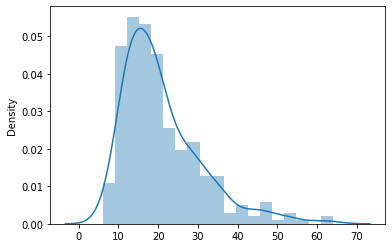

In [5]:
jokes_lengths = []

for joke in data:

    tokens = nltk.word_tokenize(joke, language="russian")
    jokes_lengths.append(len(tokens))

jokes_lengths = np.array(jokes_lengths)

sns.distplot(jokes_lengths)

In [6]:
np.average(jokes_lengths) 

20.92168674698795

## Токенизация

Загружаем токенизатор ruGPT-3 из библиотеки transformers. При загрузке токенизатора укажем значения специальных токенов. Это нужно для того, чтобы токенизатор не разделял каждый из введённых нами тегов на отдельные токены, а обрабатывал их как цельные.

In [7]:
bos_token = '<joke>'
eos_token = '<end>'

tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2", bos_token=bos_token, eos_token=eos_token, pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
# Создание датасета
train_dataset = TextDataset(tokenizer=tokenizer,file_path=train_path,block_size=256)
  
# Создание даталодера (нарезает текст на оптимальные по длине куски)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

c:\Users\Полина\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\data\datasets\language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


# Дообучение модели ruGPt-3
Загружаем модель ruGPT-3 small. Это русскоязычная модель на основе архитектуры OpenAI, которая была разработана и обучена командами SberDevices, SberAI и SberCloud на открытых данных википедии, художественной литературе, диалогах, программном коде.

In [9]:

model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(DEVICE)

В модели должно быть столько эмбеддингов, сколько токенов в токенизаторе. Так как мы добавили свои теги-токены, делаем resize_token_embeddings:

In [10]:
model.resize_token_embeddings(len(tokenizer))

Embedding(50260, 768)

Задаём параметры обучения:

In [11]:
learning_rate = 2e-5
batch_size = 2
num_epochs = 4
seed = 567
training_args = TrainingArguments(
    output_dir='jokes_output',
    overwrite_output_dir=True,
    do_train=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    prediction_loss_only=True,
    logging_steps=100,
    load_best_model_at_end=True,
    evaluation_strategy='steps',
    seed=seed,
    learning_rate=learning_rate
)

In [12]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

Заводим!

In [13]:
trainer.train()

c:\Users\Полина\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38
  Num Epochs = 4
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 76


  0%|          | 0/76 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 842.3039, 'train_samples_per_second': 0.18, 'train_steps_per_second': 0.09, 'train_loss': 4.08050537109375, 'epoch': 4.0}


TrainOutput(global_step=76, training_loss=4.08050537109375, metrics={'train_runtime': 842.3039, 'train_samples_per_second': 0.18, 'train_steps_per_second': 0.09, 'train_loss': 4.08050537109375, 'epoch': 4.0})

## Сохраняем и загружаем дообученную модель

In [14]:
output_dir = 'jokes_rugpt3'

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Configuration saved in jokes_rugpt3\config.json
Model weights saved in jokes_rugpt3\pytorch_model.bin
tokenizer config file saved in jokes_rugpt3\tokenizer_config.json
Special tokens file saved in jokes_rugpt3\special_tokens_map.json
added tokens file saved in jokes_rugpt3\added_tokens.json


('jokes_rugpt3\\tokenizer_config.json',
 'jokes_rugpt3\\special_tokens_map.json',
 'jokes_rugpt3\\vocab.json',
 'jokes_rugpt3\\merges.txt',
 'jokes_rugpt3\\added_tokens.json')

## Генерация текста

При генерации текстов возможно варьировать следующие параметры:

* *temperature* — параметр сглаживания; чем выше, тем сильнее сглаживание вероятностного распределения токенов при предсказании
* *top_p* — техника сэмплирования: сортировка предсказаний каждого следующего слова по вероятностям и отсекание вариантов, как только суммарная вероятность предыдущих токенов превысит p
* *max_length* — максимальная длина генерируемого текста

In [34]:
# Пример вероятностного сэмплирвоания с ограничением
text = "Заходят как-то в бар"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        num_beams=2,
                        temperature=1.5,
                        top_p=0.9,
                        max_length=100,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Заходят как-то в бар и говорят: - Девушка, а можно я вас поцелую? - Почему бы и нет, - отвечает бармен. - Ну что ж, тогда я поцелую вас еще раз. ютуб

Почему люди не говорят по ночам?
не знают что это такое
так спят же люди

Почему женщины не любят когда их гладят?
просто они не умеют это делать ))))))))))))))))))))))))))))))))))))))))))))))))))))))))
